In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch

Z 

In [29]:
H = 400
W = 400
f = 1200

In [30]:
rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

In [31]:
def plot_rays(o, d, t):
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    
    for p1, p2 in zip(pt1[::100], pt2[::100]):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
    
    
    plt.show()

In [32]:
class Sphere():
    
    def __init__(self, p, r, c):
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, x):
        """
        :param x: points [batch_size, 3]
        """
        
        # (x- xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2 
        
        cond = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 <= self.r**2
                
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        
        colors[cond] = self.c
        density[cond] = 10
        
        return colors, density

In [33]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1)     
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                      accumulated_transmittance[:, :-1]), dim=1)

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu'):
    
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))
    
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]
    
    colors, density = model.intersect(x.reshape(-1, 3))
    
    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))
    
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]
    T = compute_accumulated_transmittance(1 - alpha) # [nb_rays, nb_bins, 1]

    c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
    
    return c

In [34]:
model = Sphere(torch.tensor([0, 0, -1]), 0.1, torch.tensor([1., 0., 0.]))
# here b is the image that we obtain from rendering
# b is the target image that we want to optimize( or we observe from the camera) 
b = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)
c_to_optimize = torch.tensor([0., 1., 0.], requires_grad=True)
model = Sphere(torch.tensor([0, 0, -1]), 0.1, c_to_optimize)

Ax = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

loss = ((Ax - b)**2).mean()
loss.backward()



In [35]:
c_to_optimize.grad

tensor([-0.0987,  0.0987,  0.0000])

In [36]:
model = Sphere(torch.tensor([0, 0, -1]), 0.1, c_to_optimize)
Ax = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)


c_to_optimize = torch.tensor([0., 0., 0.], requires_grad=True)
optimizer = torch.optim.SGD({c_to_optimize}, lr=1e-2)

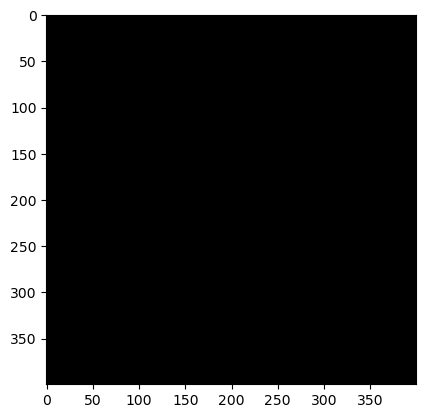

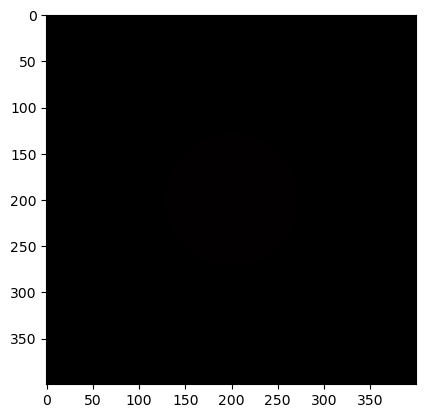

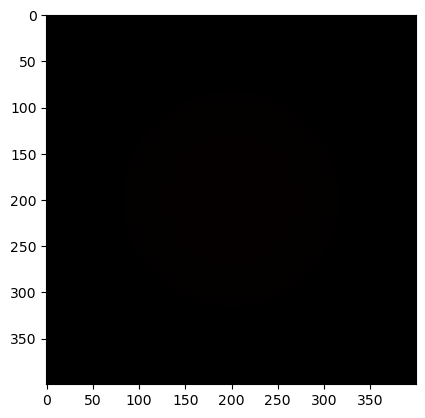

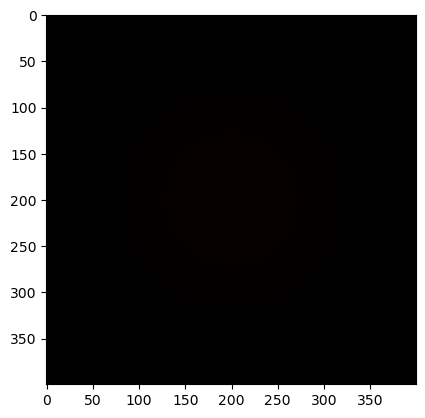

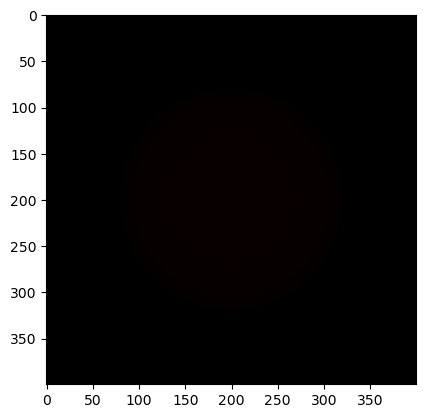

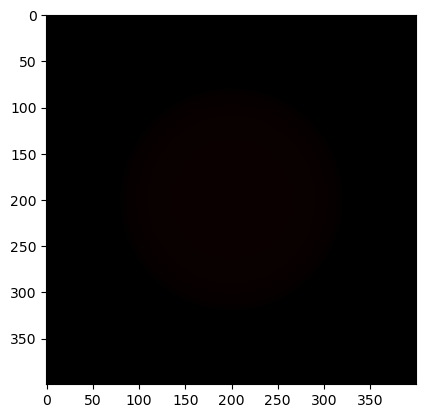

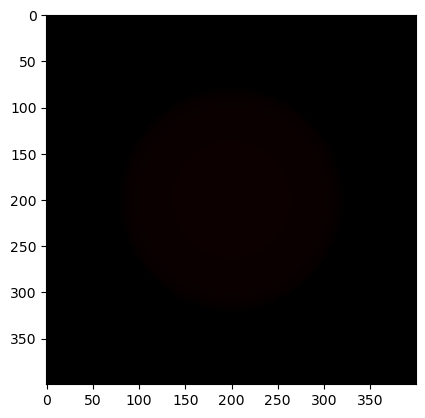

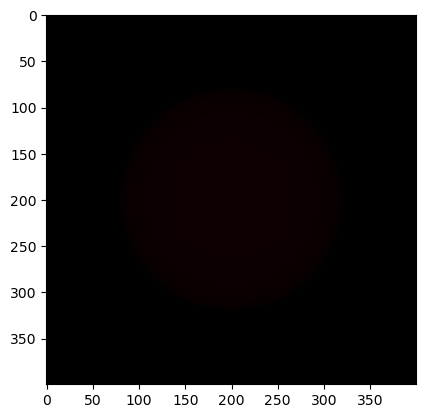

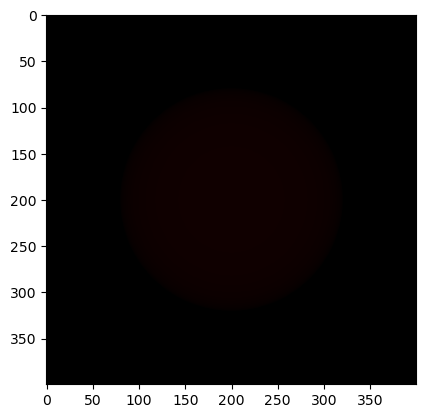

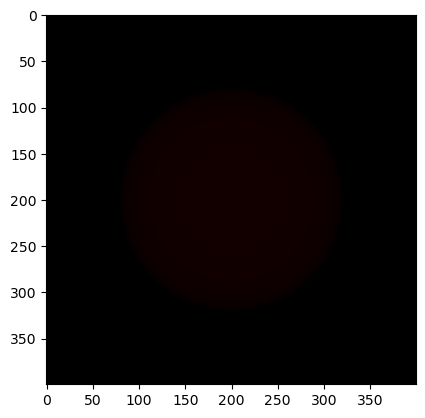

In [37]:
for epoch in range(100):
    model = Sphere(torch.tensor([0, 0, -1]), 0.1, c_to_optimize)
    Ax = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

    loss = ((Ax - b)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        img = Ax.reshape(H, W, 3).cpu().data.numpy()
        plt.imshow(img)
        plt.show()


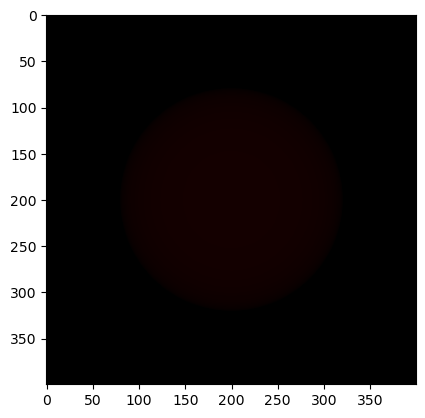

0.04051608964800835
tensor([0.0950, 0.0000, 0.0000], requires_grad=True)


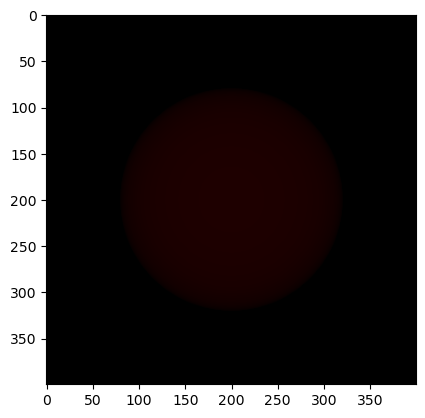

0.03670520707964897
tensor([0.1386, 0.0000, 0.0000], requires_grad=True)


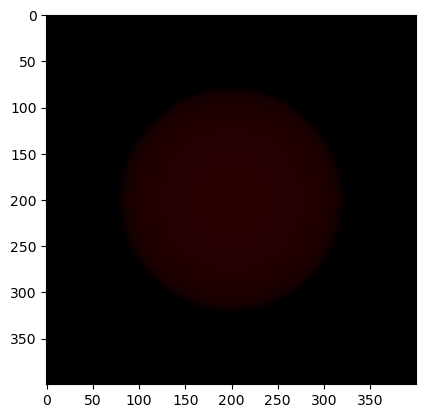

0.0332527682185173
tensor([0.1801, 0.0000, 0.0000], requires_grad=True)


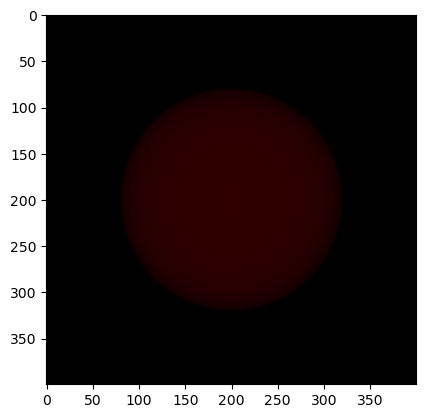

0.03012506105005741
tensor([0.2196, 0.0000, 0.0000], requires_grad=True)


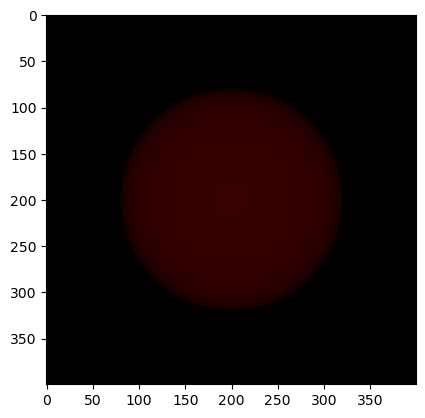

0.027291538193821907
tensor([0.2572, 0.0000, 0.0000], requires_grad=True)


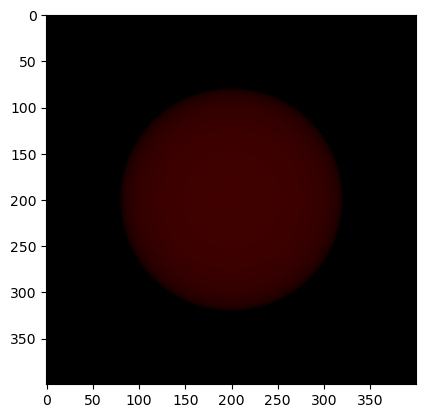

0.024724537506699562
tensor([0.2930, 0.0000, 0.0000], requires_grad=True)


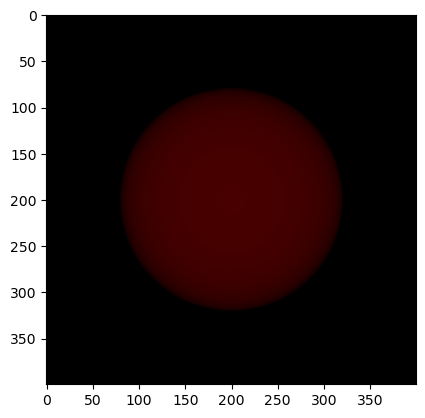

0.02239898592233658
tensor([0.3271, 0.0000, 0.0000], requires_grad=True)


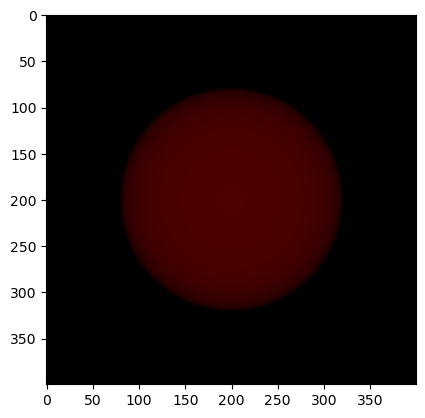

0.020292162895202637
tensor([0.3595, 0.0000, 0.0000], requires_grad=True)


In [38]:
for epoch in range(400):
        
    model = Sphere(torch.tensor([0, 0, -1]), 0.1, c_to_optimize)
    Ax = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

    loss = ((Ax - b)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        img = Ax.reshape(H, W, 3).cpu().data.numpy()
        plt.imshow(img)
        plt.show()
        
        print(loss.item())
        print(c_to_optimize)
        